# Problem-1

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
path_to_folder = "ENPM673/"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673


In [10]:
import cv2
import numpy as np

In [44]:
def detect_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Laplacian kernel
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    #Convolution with the Laplacian kernel
    laplacian = cv2.filter2D(gray, cv2.CV_64F, laplacian_kernel)
    fm = laplacian.var()
    return fm < threshold


In [53]:
def find_paper_corners(image, blur_threshold=70):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # thresholding
    _, binary_masking = cv2.threshold(blurred, 200, 250, cv2.THRESH_BINARY)
    binary_image = binary_masking.astype(np.uint8)
    # Canny edge detection
    edges = cv2.Canny(binary_image, 200, 250)
    # harris corner detection
    corners = cv2.cornerHarris(gray, 3, 7, 0.05)
    corners = cv2.dilate(corners, None)
    #Hough Lines(horizontal lines)
    houghlines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=80, maxLineGap=5)

    # getting corner positions
    cornerpositions = np.argwhere(corners > 0.4 * corners.max())

    for coord in cornerpositions:
        x_coord, y_coord = coord[1], coord[0]
        cv2.circle(image, (x_coord, y_coord), 5, (0, 0, 255), -1)

    #drawing  detected lines
    if houghlines is not None:
        for line in houghlines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (255 ,0 , 0), 4)

    return image

In [61]:
input_vid = '/content/drive/MyDrive/ENPM673/Project-2/proj2_v2.mp4'
output_vid = '/content/drive/MyDrive/ENPM673/Project-2/proj2_output.mp4'

cap = cv2.VideoCapture(input_vid)
fps = cap.get(5)
framewidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_vid, cv2.VideoWriter_fourcc(*'mp4v'), fps, (framewidth, frameheight))

blurry_frame_count = 0

In [55]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if detect_blurry(frame):
        blurry_frame_count += 1
        continue

    frame_processed = find_paper_corners(frame)
    out.write(frame_processed)

cap.release()
out.release()

print("Blurry frames removed:", blurry_frame_count)


Blurry frames removed: 164


# Problem-2(A)

# Reason to select SIFT:
Due to a number of significant benefits, SIFT (Scale-Invariant Feature Transform) features are frequently utilized in imagie stitching applications. First of all, they demonstrate scale invariance, which is important for stitching images collected at different distances since it means they can recognize characteristics across images successfully despite scale differences. Second, even in cases when photos are taken with a little rotation, accurate matching is made possible by the rotational invariance of SIFT characteristics. Their uniqueness guarantees consistent matching, especially in settings with recurring textures or patterns. Furthermore, SIFT characteristics are resistant to changes in illumination, ensuring uniformity across photos taken in a variety of lighting scenarios. Ultimately, their geometric stability makes it possible to precisely estimate the homographies between succeeding pictures, which is necessary for smooth panoramic mosaicing.

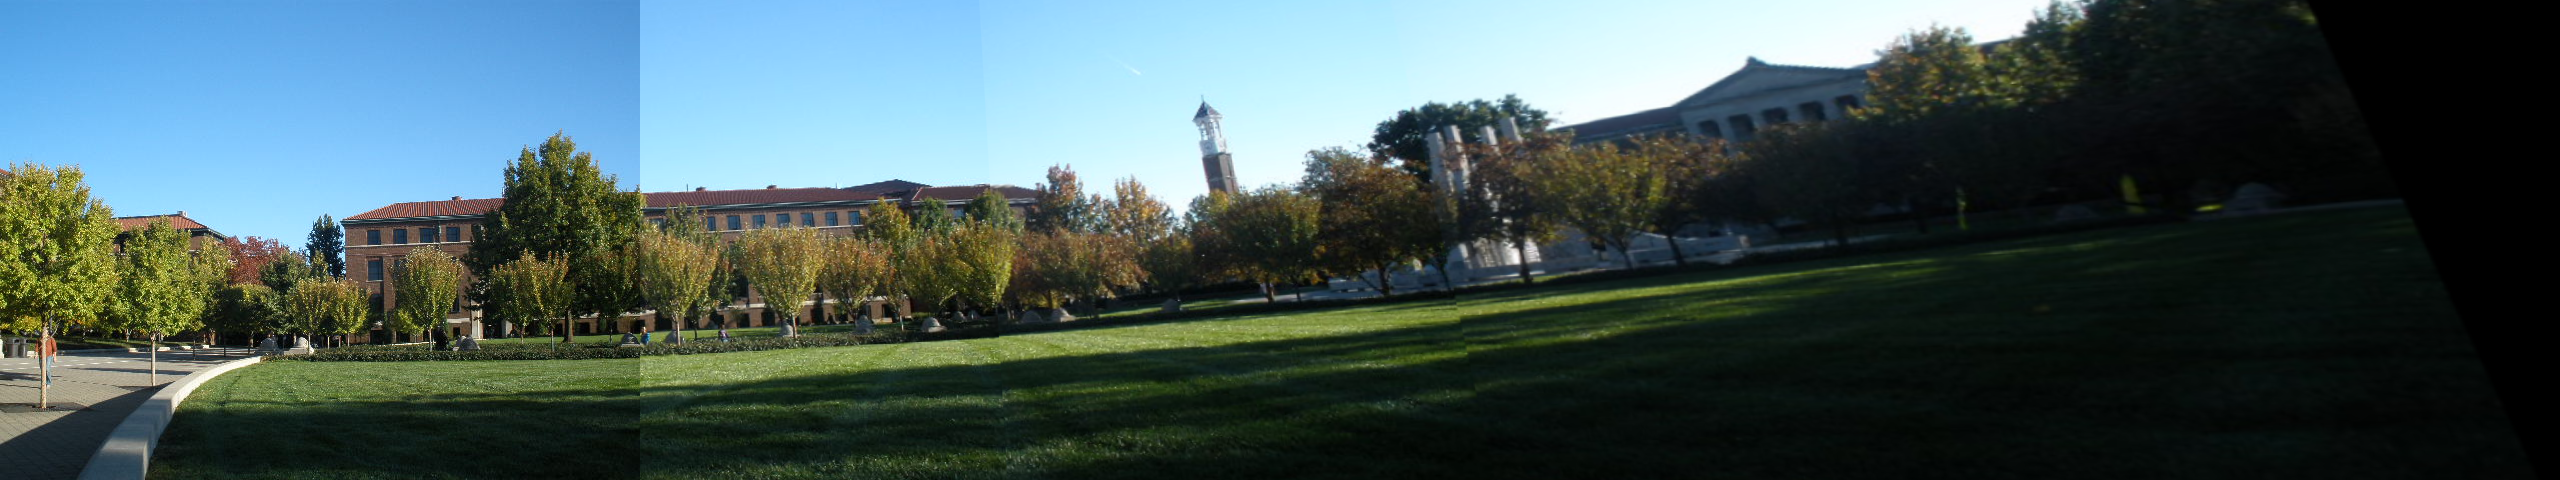

True

In [62]:
from google.colab.patches import cv2_imshow

# Extracting Features
sift = cv2.SIFT_create()
keypoints = []
descriptors = []
images = []
for i in range(1, 5):
    img = cv2.imread(f'/content/drive/MyDrive/ENPM673/Project-2/image_{i}.JPG')
    images.append(img)
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

# feature matching (between consecutive images)
bf = cv2.BFMatcher()
matches = []

for i in range(3):
    matches.append(bf.match(descriptors[i], descriptors[i+1]))

#Computing Homographies
homographies = []

for i in range(3):
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in matches[i]]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    homographies.append(H)

# Image Blending and Warping
image1 = cv2.imread('/content/drive/MyDrive/ENPM673/Project-2/image_1.JPG')
image2 = cv2.imread('/content/drive/MyDrive/ENPM673/Project-2/image_2.JPG')
image3 = cv2.imread('/content/drive/MyDrive/ENPM673/Project-2/image_3.JPG')
image4 = cv2.imread('/content/drive/MyDrive/ENPM673/Project-2/image_4.JPG')

def homography_compute(keypoints, img1, img2, matches, i):
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in matches[i]]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    warped_img = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    warped_img[0:img1.shape[0], 0:img2.shape[1]] = img2

    return warped_img

rt = homography_compute(keypoints, image1, image2, matches, 0)
result = homography_compute(keypoints, rt, image3, matches, 1)
result = homography_compute(keypoints, result, image4, matches, 2)
cv2_imshow(result)
cv2.imwrite('/content/drive/MyDrive/ENPM673/Project-2/panorama.jpg', result)


# Problem-2(B)

For a number of reasons, panoramic mosaicing often performs better when the camera is restricted to rotating at its camera center.

Simplified Geometry: Planar homographies are an efficient way to depict the transition between successive pictures as the camera revolves about its optical center, or camera center. This facilitates precise alignment by streamlining the geometric connection between the pictures.

Estimating Homography: By rotating the camera about its optical center, the planar structure of the picture is preserved, which facilitates the estimation of the homography, or the mapping of points from one image to another. Assuming planar scenes makes estimate easier. Homographies are the transition between two perspective views of a planar surface.

Consistent Projective Geometry: The projective geometry is guaranteed to be constant throughout photos by centering the camera rotation. Because each image can be precisely aligned using the same homography, this uniformity makes the process of stitching images much easier.

Decreased Distortions: By rotating the camera about its optical center, parallax effects-related distortions are reduced. When things appear to shift relative to each other as the camera moves, this phenomenon is known as parallax. Parallax effects are lessened by rotating the camera around its optical center, which produces a panoramic view with less distortion and more precise alignment.

easier Stitching: Stitching algorithms are able to produce a seamless panorama by more precisely aligning and blending pictures when there is less distortion and consistent projective geometry. This lessens the possibility that the final stitched picture may have obvious artifacts or misalignments.